<a href="https://colab.research.google.com/github/bipinr8/MH_cash_deployment/blob/main/Morgan_Housel_Cash_deployment_strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Morgan Housel's cash deployment strategy**.
Morgan Housel once wrote a strategy to deploy surplus cash when market crashes, considering the rarity of crashes of big magnitudes. It goes like this:

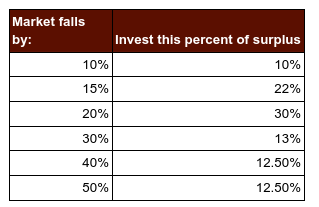


For more details, do read https://www.fool.com/investing/general/2013/08/19/what-i-plan-to-do-when-the-market-crashes.aspx

This is an analysis of investments done solely based on this cash deployment strategy. Do note that this is not an analysis of Morgan Housel's original cash deployment strategy.

For more details on the analysis, refer to https://boringfinance.wordpress.com/2023/08/19/morgan-housels-cash-deployment-strategy/

This is created using Google Colab.

In [1]:
from google.colab import drive # to mount Google drive for reading from and write into files
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#Importing libraries
import numpy as np  # useful for many scientific computing in Python
import pandas as pd # primary data structure library

In [3]:
# reading excel file into data frame
df_source = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/MH/Source_data.xlsx',
                       sheet_name='Sheet1')

print ('Data read into a pandas dataframe!')

Data read into a pandas dataframe!


In [4]:

# checking data frame
df_source.head()

,Date,Liquid NAV,Nifty 100
0,2003-01-01,1186.99,1000.00
1,2003-01-02,1187.16,1008.03
2,2003-01-03,1187.35,1004.49
3,2003-01-06,1187.92,999.85
4,2003-01-07,1188.09,997.81


In [5]:
# view df details
df_source.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5068 entries, 0 to 5067
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        5068 non-null   datetime64[ns]
 1   Liquid NAV  5068 non-null   float64       
 2   Nifty 100   5068 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 118.9 KB


In [6]:
# import required libraries for graph plot
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
print ('Matplotlib version: ', mpl.__version__ )

# choosing plot style
print(plt.style.available)
mpl.style.use(['ggplot'])

Matplotlib version:  3.7.1
['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


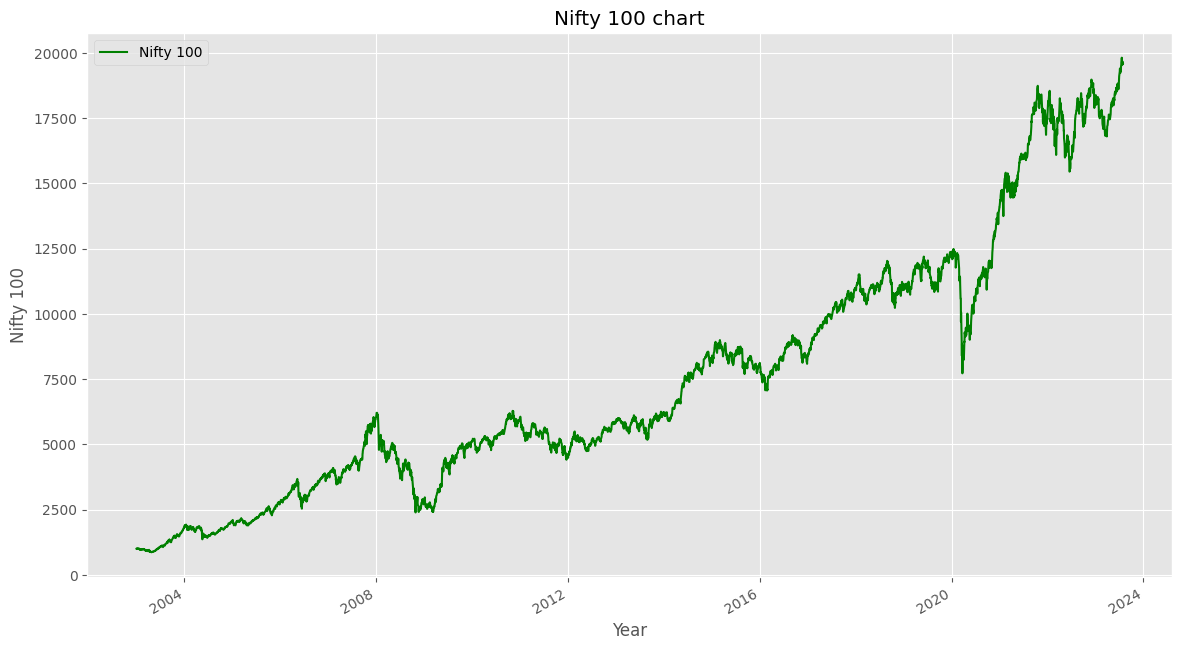

In [7]:

# creating new dataframe graphdf with 2 columns Date and Nifty
graphdf=df_source[['Date','Nifty 100']]

# plotting the line chart with 'Date' as X axis
graphdf.set_index('Date').plot(kind='line',figsize=(14,8),color='green')
plt.title('Nifty 100 chart')
plt.xlabel('Year')
plt.ylabel('Nifty 100')
plt.savefig('/content/drive/MyDrive/Colab Notebooks/MH/pic01.png')
plt.show()

In [8]:
# declarations
# here what proportion of cash to be deployed under various drawdown cases are defined
daily_sip = 100
red_50 = 1 # when 50% crash occures, complete balace cash is invested (125/125)
red_40 = 0.5 # at 40% crash, half of balance cash is invested (125/250)
red_30 = 130/380 # at 30% crash, 130 out of 380 is invested
red_20 = 300/680
red_15 = 220/900
red_10 = 0.1 # at 10% crash, 10% of balance cash is invested (100/1000)

In [9]:
# creating a new data frame
df2=df_source.copy()

# counting number of rows
var_rows=len(df2.index)

# creating a new data frame to store peaks and flags for whether drawdown from this peak has happened
df_peak=pd.DataFrame(columns=['Date','Peak','D10','D15','D20','D30','D40','D50'])

# declaring a new variable to mark start of peak data frame
j=0

# adding columns and setting first row values
df2.loc[0,'Peak']=df2.loc[0,'Nifty 100'] # this col will have peak values of index till that date; first row peak = starting value
df2.loc[0,'Drawdown']=0.0 # this col will show drawdown from peak; first row peak = starting value
df2.loc[0,'Sip inv']=daily_sip # daily sip investment; first day's investment
df2.loc[0,'Sip net inv']=df2.loc[0,'Sip inv'] # col to store total sum of money invested
df2.loc[0,'Sip units']=df2.loc[0,'Sip inv']/df2.loc[0,'Nifty 100'] # units purchased on the first day
df2.loc[0,'Sip accumulated units']=df2.loc[0,'Sip units'] # col for accumulated units via sip; first day's value = first day's units purchased
df2.loc[0,'Sip market value']=df2.loc[0,'Sip accumulated units']*df2.loc[0,'Nifty 100'] # market value of sip
df2.loc[0,'Liquid inv']=daily_sip
df2.loc[0,'Liquid red units']=0
df2.loc[0,'Liquid add units']=df2.loc[0,'Liquid inv']/df2.loc[0,'Liquid NAV']
df2.loc[0,'Liquid net units']=df2.loc[0,'Liquid add units']
df2.loc[0,'Liquid value']=df2.loc[0,'Liquid net units']*df2.loc[0,'Liquid NAV']
df2.loc[0,'MH SIP inv']=0 # no investments done on the first day
df2.loc[0,'MH SIP net inv']=0 # no net investments on first day
df2.loc[0,'MH SIP units']=0
df2.loc[0,'MH SIP net units']=0
df2.loc[0,'MH SIP value']=0
df2.loc[0,'MH SIP + Liquid value']=df2.loc[0,'MH SIP value']+df2.loc[0,'Liquid value']

# setting first row values for peak data frame
df_peak.loc[0,'Date']=df2.loc[0,'Date']
df_peak.loc[0,'Peak']=df2.loc[0,'Peak']
df_peak.loc[0,'D10']=0 # 0 flags a 10% drawdown hasn't happened from this peak
df_peak.loc[0,'D15']=0
df_peak.loc[0,'D20']=0
df_peak.loc[0,'D30']=0
df_peak.loc[0,'D40']=0
df_peak.loc[0,'D50']=0

for i in range(1,var_rows):
  df2.loc[i,'Peak']=df2.loc[:i,'Nifty 100'].max() # for all days from the beginning till current date, max is stored in col. Peak
  df2.loc[i,'Drawdown']=(df2.loc[i,'Nifty 100']-df2.loc[i,'Peak'])*100/df2.loc[i,'Peak'] # drawdown is what percent current index value is down from the peak observed till that date
  df2.loc[i,'Sip inv']=daily_sip
  df2.loc[i,'Sip net inv']=df2.loc[i-1,'Sip net inv']+df2.loc[i,'Sip inv']
  df2.loc[i,'Sip units']=df2.loc[i,'Sip inv']/df2.loc[i,'Nifty 100']
  df2.loc[i,'Sip accumulated units']=df2.loc[i-1,'Sip accumulated units']+df2.loc[i,'Sip units']
  df2.loc[i,'Sip market value']=df2.loc[i,'Sip accumulated units']*df2.loc[i,'Nifty 100']
  df2.loc[i,'Liquid inv']=daily_sip
  df2.loc[i,'Liquid add units']=df2.loc[i,'Liquid inv']/df2.loc[i,'Liquid NAV']
  if (df2.loc[i,'Peak']>df2.loc[i-1,'Peak']): # a new peak is observed
    j=j+1
    df_peak.loc[j,'Peak']=df2.loc[i,'Peak'] # the new peak now stored in peak data frame
    df_peak.loc[j,'Date']=df2.loc[i,'Date']
    df_peak.loc[j,'D10']=0 # setting no drawdowns happened from this new peak
    df_peak.loc[j,'D15']=0
    df_peak.loc[j,'D20']=0
    df_peak.loc[j,'D30']=0
    df_peak.loc[j,'D40']=0
    df_peak.loc[j,'D50']=0
  if (df2.loc[i,'Drawdown']<=-50):
    if (df_peak.loc[j,'D50']==0): # if 50% drawdown is happening for the first time since the latest peak
      df_peak.loc[j,'D50']=1 # marking that 50% drawdown from new peak is addressed
      df_peak.loc[j,'D40']=1 # also marking all lesser drawdowns as addressed
      df_peak.loc[j,'D30']=1
      df_peak.loc[j,'D20']=1
      df_peak.loc[j,'D15']=1
      df_peak.loc[j,'D10']=1
      df2.loc[i,'Liquid red units']=(df2.loc[i-1,'Liquid net units']+df2.loc[i,'Liquid add units'])*red_50 # complete units are redeemed from liquid
    else:
      df2.loc[i,'Liquid red units']=0 # 50% drawdown from this peak is not happening for the first time, so no redemption
  elif (df2.loc[i,'Drawdown']<=-40):
    if (df_peak.loc[j,'D40']==0):
      df_peak.loc[j,'D40']=1
      df_peak.loc[j,'D30']=1
      df_peak.loc[j,'D20']=1
      df_peak.loc[j,'D15']=1
      df_peak.loc[j,'D10']=1
      df2.loc[i,'Liquid red units']=(df2.loc[i-1,'Liquid net units']+df2.loc[i,'Liquid add units'])*red_40 # defined part of units are redeemed from liquid
    else:
      df2.loc[i,'Liquid red units']=0
  elif (df2.loc[i,'Drawdown']<=-30):
    if (df_peak.loc[j,'D30']==0):
      df_peak.loc[j,'D30']=1
      df_peak.loc[j,'D20']=1
      df_peak.loc[j,'D15']=1
      df_peak.loc[j,'D10']=1
      df2.loc[i,'Liquid red units']=(df2.loc[i-1,'Liquid net units']+df2.loc[i,'Liquid add units'])*red_30 # defined part of units are redeemed from liquid
    else:
      df2.loc[i,'Liquid red units']=0
  elif (df2.loc[i,'Drawdown']<=-20):
    if (df_peak.loc[j,'D20']==0):
      df_peak.loc[j,'D20']=1
      df_peak.loc[j,'D15']=1
      df_peak.loc[j,'D10']=1
      df2.loc[i,'Liquid red units']=(df2.loc[i-1,'Liquid net units']+df2.loc[i,'Liquid add units'])*red_20 # defined part of units are redeemed from liquid
    else:
      df2.loc[i,'Liquid red units']=0
  elif (df2.loc[i,'Drawdown']<=-15):
    if (df_peak.loc[j,'D15']==0):
      df_peak.loc[j,'D15']=1
      df_peak.loc[j,'D10']=1
      df2.loc[i,'Liquid red units']=(df2.loc[i-1,'Liquid net units']+df2.loc[i,'Liquid add units'])*red_15 # defined part of units are redeemed from liquid
    else:
      df2.loc[i,'Liquid red units']=0
  elif (df2.loc[i,'Drawdown']<=-10):
    if (df_peak.loc[j,'D10']==0):
      df_peak.loc[j,'D10']=1
      df2.loc[i,'Liquid red units']=(df2.loc[i-1,'Liquid net units']+df2.loc[i,'Liquid add units'])*red_10 # defined part of units are redeemed from liquid
    else:
      df2.loc[i,'Liquid red units']=0
  else:
    df2.loc[i,'Liquid red units']=0 # no redemption from liquid
  df2.loc[i,'Liquid net units']=df2.loc[i-1,'Liquid net units']+df2.loc[i,'Liquid add units']-df2.loc[i,'Liquid red units']
  df2.loc[i,'Liquid value']=df2.loc[i,'Liquid net units']*df2.loc[i,'Liquid NAV']
  df2.loc[i,'MH SIP inv']=df2.loc[i,'Liquid NAV']*df2.loc[i,'Liquid red units'] # what is redeemed from liquid is invested into MH SIP
  df2.loc[i,'MH SIP net inv']=df2.loc[i-1,'MH SIP net inv']+df2.loc[i,'MH SIP inv'] # net investments = past net + current
  df2.loc[i,'MH SIP units']=df2.loc[i,'MH SIP inv']/df2.loc[i,'Nifty 100']
  df2.loc[i,'MH SIP net units']=df2.loc[i-1,'MH SIP net units']+df2.loc[i,'MH SIP units']
  df2.loc[i,'MH SIP value']=df2.loc[i,'MH SIP net units']*df2.loc[i,'Nifty 100']
  df2.loc[i,'MH SIP + Liquid value']=df2.loc[i,'MH SIP value']+df2.loc[i,'Liquid value']

In [10]:
df2.tail()

,Date,Liquid NAV,Nifty 100,Peak,Drawdown,Sip inv,Sip net inv,Sip units,Sip accumulated units,Sip market value,...,Liquid red units,Liquid add units,Liquid net units,Liquid value,MH SIP inv,MH SIP net inv,MH SIP units,MH SIP net units,MH SIP value,MH SIP + Liquid value
5063,2023-07-24,4478.1362,19540.45,19811.9,-1.370136,100.0,506400.0,0.005118,114.467512,2.236747e+06,...,0.0,0.022331,21.013996,94103.534500,0.0,507986.533382,0.0,96.676979,1.889112e+06,1.983215e+06
5064,2023-07-25,4478.9060,19566.90,19811.9,-1.236631,100.0,506500.0,0.005111,114.472623,2.239874e+06,...,0.0,0.022327,21.036323,94219.711074,0.0,507986.533382,0.0,96.676979,1.891669e+06,1.985888e+06
5065,2023-07-26,4479.7627,19662.00,19811.9,-0.756616,100.0,506600.0,0.005086,114.477709,2.250861e+06,...,0.0,0.022323,21.058645,94337.732892,0.0,507986.533382,0.0,96.676979,1.900863e+06,1.995200e+06
5066,2023-07-27,4480.5255,19566.70,19811.9,-1.237640,100.0,506700.0,0.005111,114.482820,2.240051e+06,...,0.0,0.022319,21.080964,94453.796426,0.0,507986.533382,0.0,96.676979,1.891649e+06,1.986103e+06
5067,2023-07-28,4481.2044,19580.65,19811.9,-1.167228,100.0,506800.0,0.005107,114.487927,2.241748e+06,...,0.0,0.022315,21.103279,94568.108293,0.0,507986.533382,0.0,96.676979,1.892998e+06,1.987566e+06


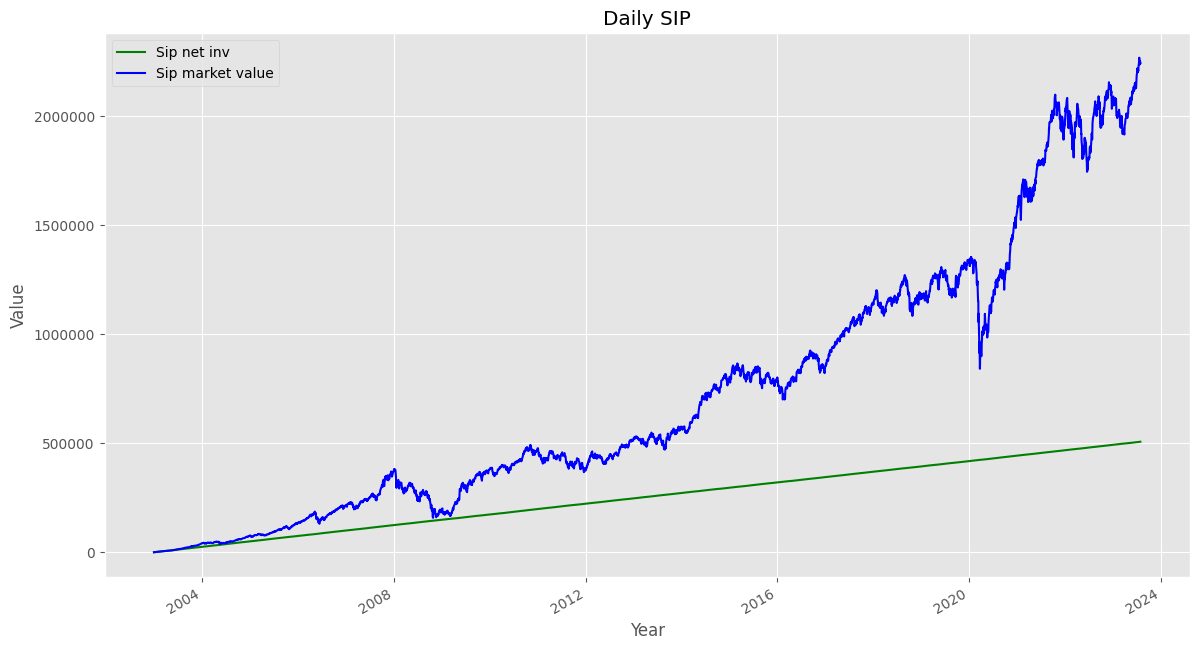

In [11]:
# creating new dataframe graphdf with 2 columns Date and Nifty
graphdf = df2[['Date', 'Sip net inv', 'Sip market value']]

# plotting the line chart with 'Date' as X axis
ax = graphdf.set_index('Date').plot(kind='line', figsize=(14, 8), color=('green', 'blue'))

# Set y-axis label format to display full numbers
ax.yaxis.set_major_formatter(mticker.ScalarFormatter(useMathText=True))
ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%0.0f'))

# Set other labels and title
plt.title('Daily SIP')
plt.xlabel('Year')
plt.ylabel('Value')

# Save and show the plot
plt.savefig('/content/drive/MyDrive/Colab Notebooks/MH/pic02.png')
plt.show()


In [12]:
df_peak.head()
# writing to excel
df_peak.to_excel('/content/drive/MyDrive/Colab Notebooks/MH/peaks.xlsx', sheet_name='peaks', index=False)

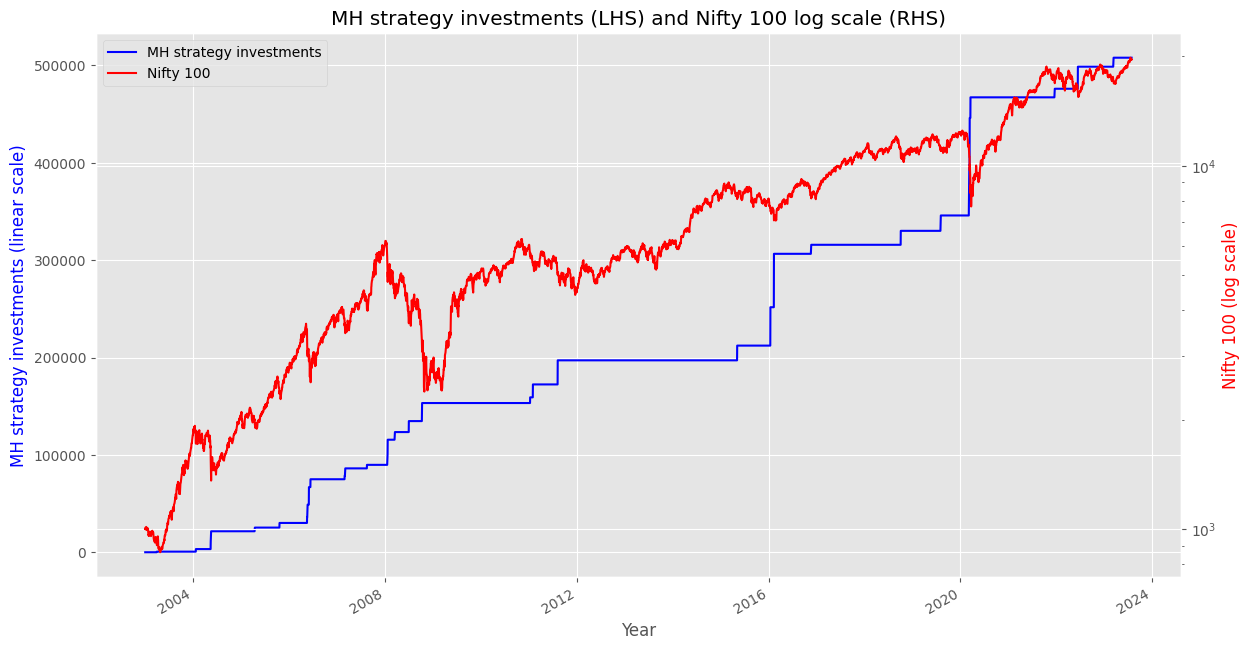

In [13]:
# creating new dataframe graphdf with 2 columns Date, Liquid value, and Nifty 100
graphdf = df2[['Date', 'MH SIP net inv', 'Nifty 100']]

# Plotting the line chart with 'Date' as X axis
fig, ax1 = plt.subplots(figsize=(14, 8))
ax2 = ax1.twinx()  # Create a secondary y-axis

# Plot the first series on the left y-axis (logarithmic scale)
graphdf.set_index('Date')['MH SIP net inv'].plot(kind='line', ax=ax1, color='blue', label='MH strategy investments')
#ax1.set_yscale('log')  # Set the left y-axis to logarithmic scale

# Plot the second series on the right y-axis (logarithmic scale)
graphdf.set_index('Date')['Nifty 100'].plot(kind='line', ax=ax2, color='red', label='Nifty 100')
ax2.set_yscale('log')  # Set the right y-axis to logarithmic scale

# Set labels and title
ax1.set_xlabel('Year')
ax1.set_ylabel('MH strategy investments (linear scale)', color='blue')
ax2.set_ylabel('Nifty 100 (log scale)', color='red')
plt.title('MH strategy investments (LHS) and Nifty 100 log scale (RHS)')

# Show a single legend for both series
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.savefig('/content/drive/MyDrive/Colab Notebooks/MH/pic03.png')
plt.show()

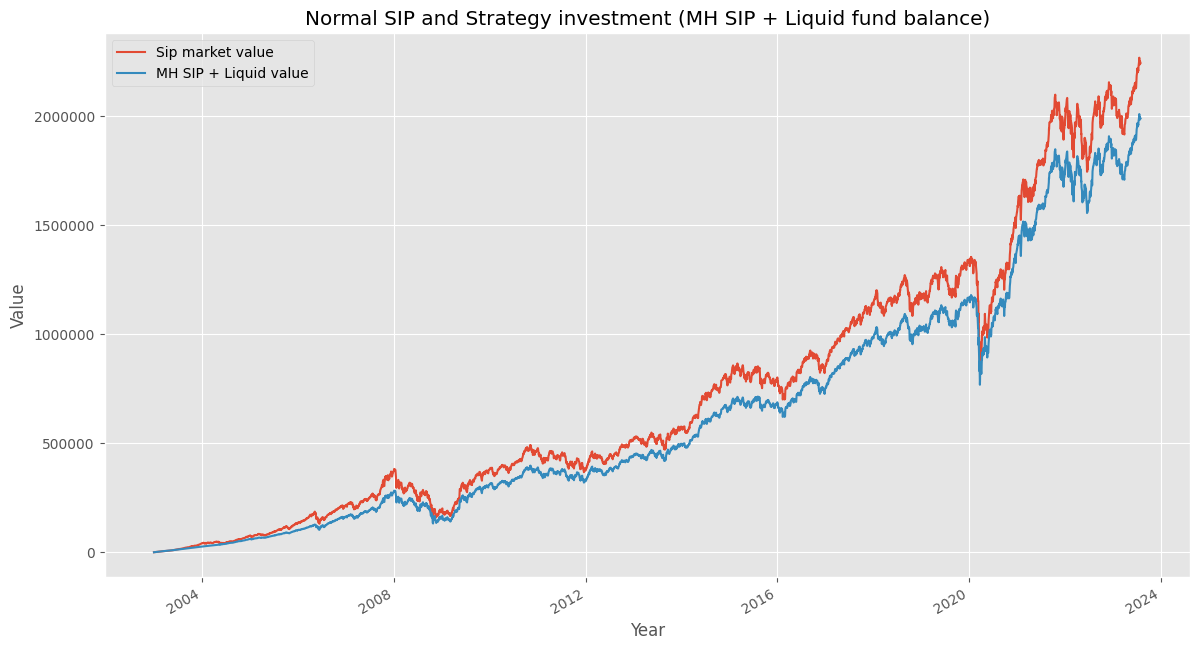

In [14]:
# creating new dataframe graphdf with 2 columns Date and Nifty
graphdf = df2[['Date', 'Sip market value', 'MH SIP + Liquid value']]

# plotting the line chart with 'Date' as X axis
ax = graphdf.set_index('Date').plot(kind='line', figsize=(14, 8))

# Set y-axis label format to display full numbers
ax.yaxis.set_major_formatter(mticker.ScalarFormatter(useMathText=True))
ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%0.0f'))

# Set other labels and title
plt.title('Normal SIP and Strategy investment (MH SIP + Liquid fund balance)')
plt.xlabel('Year')
plt.ylabel('Value')

# Save and show the plot
plt.savefig('/content/drive/MyDrive/Colab Notebooks/MH/pic04.png')
plt.show()


In [15]:
# writing to excel
df2.to_excel('/content/drive/MyDrive/Colab Notebooks/MH/output.xlsx', sheet_name='data', index=False)

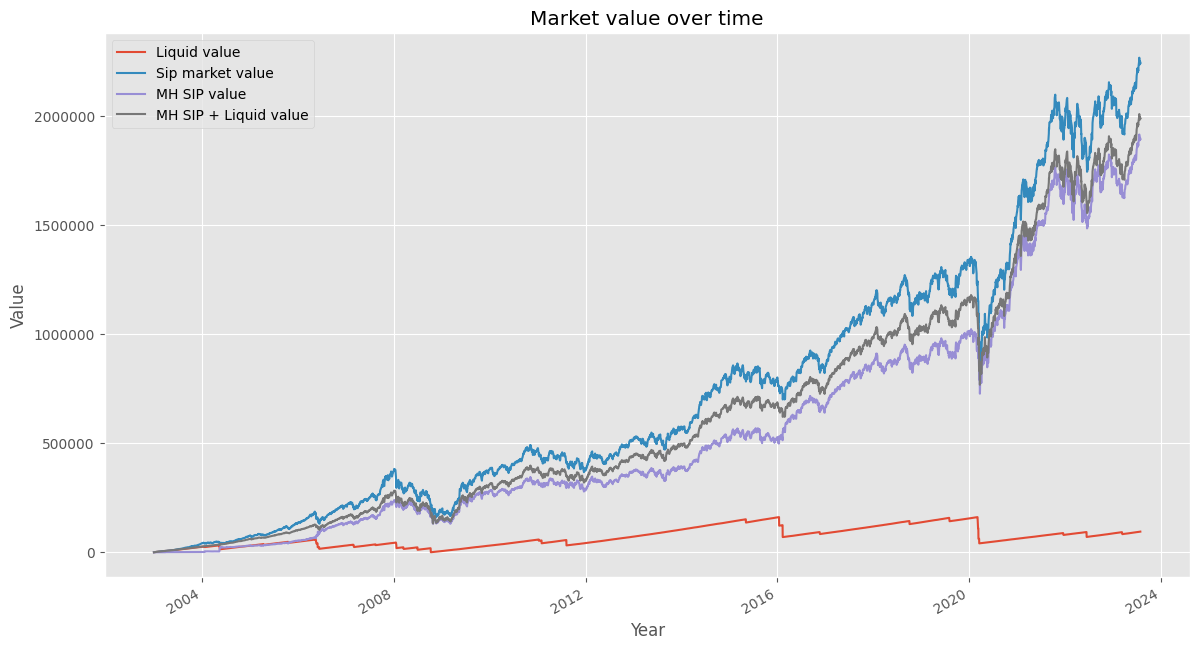

In [16]:
# creating new dataframe graphdf with 2 columns Date and Nifty
graphdf = df2[['Date', 'Liquid value', 'Sip market value', 'MH SIP value', 'MH SIP + Liquid value']]

# plotting the line chart with 'Date' as X axis
ax = graphdf.set_index('Date').plot(kind='line', figsize=(14, 8))

# Set y-axis label format to display full numbers
ax.yaxis.set_major_formatter(mticker.ScalarFormatter(useMathText=True))
ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%0.0f'))

# Set other labels and title
plt.xlabel('Year')
plt.ylabel('Value')
plt.title('Market value over time')

# Save and show the plot
plt.savefig('/content/drive/MyDrive/Colab Notebooks/MH/pic05.png')
plt.show()
